In [3]:
import os
import mne
from mne_bids import BIDSPath
import numpy as np

bids_root = os.path.join(mne.get_config('MNE_DATA'), 'derivatives', 'mne-bids-pipeline', 'STBF-ERP_CORE')
path = BIDSPath(root=bids_root, subject='002', task='P3', datatype='eeg', processing='clean', suffix='epo', check=False)
epochs = mne.read_epochs(path.match()[0])
epochs.metadata['label'] = epochs.metadata['event_name'].str.startswith('stimulus/target')

Reading /data/mne_data/derivatives/mne-bids-pipeline/STBF-ERP_CORE/sub-002/ses-P3/eeg/sub-002_ses-P3_task-P3_proc-clean_epo.fif ...
    Found the data of interest:
        t =    -203.12 ...    1000.00 ms
        0 CTF compensation matrices available
Adding metadata with 28 columns
200 matching events found
No baseline correction applied
0 projection items activated


In [4]:
epochs.drop_channels(['P9', 'P10'])
epochs.crop(tmin=0.1, tmax=0.6)
epochs.decimate(2)
epochs.reorder_channels([
    'FP1', 'FP2',
    'F3', 'F7', 'Fz', 'F4', 'F8',
    'FC3', 'FCz', 'FC4',
    'C3', 'C5', 'Cz', 'C4', 'C6',
    'CPz',
    'P3', 'P7', 'Pz', 'P4', 'P8',
    'PO7', 'PO3', 'PO8', 'PO4',
    'O1', 'Oz', 'O2',
    'HEOG','VEOG'
])
epochs.pick_types(eeg=True, eog=True)


/tmp/ipykernel_66825/3663005237.py:3: RuntimeWarning: The measurement information indicates a low-pass frequency of 16 Hz. The decim=2 parameter will result in a sampling frequency of 32 Hz, which can cause aliasing artifacts.
  epochs.decimate(2)


Number of events,200
Events,stimulus/non-target/12: 8stimulus/non-target/13: 5stimulus/non-target/14: 8stimulus/non-target/15: 11stimulus/non-target/21: 5stimulus/non-target/23: 9stimulus/non-target/24: 7stimulus/non-target/25: 11stimulus/non-target/31: 4stimulus/non-target/32: 9stimulus/non-target/34: 9stimulus/non-target/35: 10stimulus/non-target/41: 11stimulus/non-target/42: 5stimulus/non-target/43: 4stimulus/non-target/45: 12stimulus/non-target/51: 16stimulus/non-target/52: 5stimulus/non-target/53: 7stimulus/non-target/54: 4stimulus/target/11: 8stimulus/target/22: 8stimulus/target/33: 8stimulus/target/44: 8stimulus/target/55: 8
Time range,0.094 – 0.594 sec
Baseline,off


In [5]:
X_train = epochs[:100].get_data()
y_train = epochs.metadata['label'][:100].values

X_test = epochs[100:].get_data()
y_test = epochs.metadata['label'][100:].values

In [6]:
from decode.classifier import UnitVarianceChannelScaler

scaler = UnitVarianceChannelScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
from decode.cov import FullCovariance
from decode.stbf import LCMVBeamformer

cov_estimator=FullCovariance(shrinkage='oas')
stbf = LCMVBeamformer(cov_estimator=cov_estimator)
stbf.fit(X_train, y_train)

LCMVBeamformer(cov_estimator=FullCovariance(shrinkage='oas'))

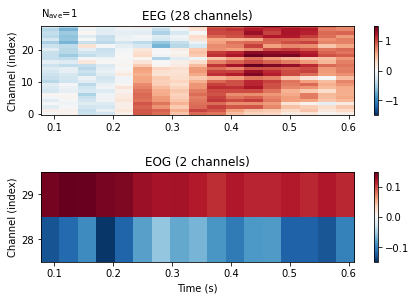

In [8]:
ap = mne.EvokedArray(stbf.lead_field_, epochs.info, epochs.tmin)
ap.plot_image(units=dict(eeg='', eog=''), scalings=dict(eeg=1, eog=1));

<AxesSubplot:>

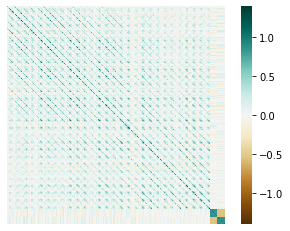

In [9]:
from util.viz import plot_cov

plot_cov(stbf.cov_estimator_.covariance_)

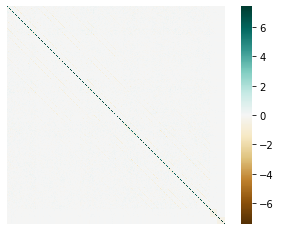

In [10]:
plot_cov(stbf.cov_estimator_.precision_);

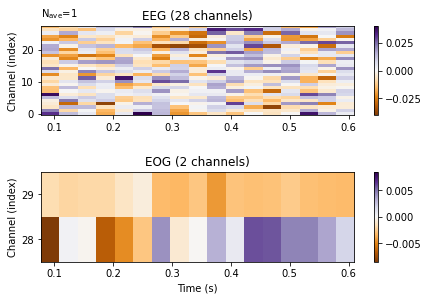

In [11]:
weights = mne.EvokedArray(stbf.weights_, epochs.info, epochs.tmin)
weights.plot_image(units=dict(eeg='', eog=''), scalings=dict(eeg=1, eog=1), cmap='PuOr');

<AxesSubplot:>

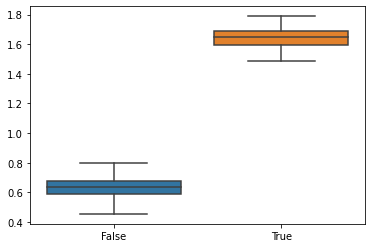

In [12]:
import seaborn as sns

scores_train = stbf.transform(X_train).squeeze()
sns.boxplot(x=y_train, y=scores_train)

<AxesSubplot:>

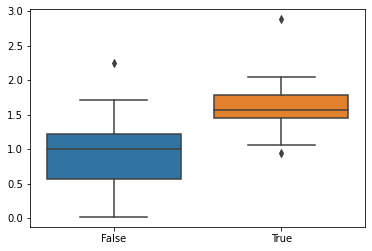

In [13]:
scores_test = stbf.transform(X_test).squeeze()
sns.boxplot(x=y_test, y=scores_test)